# Ungraded Lab:  Overfitting in Logistic Regression.

The lectures describe **Overfitting**. This is when the model follows the data too closely and does not generalize well. In this lab we will explore overfitting in logistic regression and how regularization can improve situation.


# Outline
- [Tools](#tools)
- [Dataset](#dataset)
- [Polynomial Feature Map](#FeatureMap)
- [Fit the Model](#FitModel)
- [Reducing Overfitting](#ReduceOverfitting)

# Overfitting
In this lab, we will explore how overfitting happens and what can be done about it.
- Create a logistic dataset with an irregular boundary
- Create an overfitting problem
    - polynomial Regression and Feature mapping
- Regularization to reduce overfitting
<a name='tools'></a>
## Tools 
- We have not yet developed all the capabilities to do gradient decent with regularization so we will utilized sklearn's LogisticRegression capabilities explored briefly in a previous lab. 
- Plotting is very useful when exploring decision boundaries. We will utilize matplotlib. Producing these plots is quite involved so helper routines are provided below.
- We will create a polynomial feature set. `map_features` is provided to simplify that process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)
    plt.legend()
    plt.xlabel("X[:,0]")
    plt.ylabel("X[:,1]")

In [3]:
def plot_decision_boundary(x0r,x1r, y,predict):
    """
    Plots a decision boundary 
     Args:
      x0r : (array_like Shape (1,1)) range (min, max) of x0
      x1r : (array_like Shape (1,1)) range (min, max) of x1
      y   : (array_like Shape (m, )) target values of y
      predict : function to predict z values    
    """

    h = .01  # step size in the mesh
    # create a mesh to plot in
    xx, yy = np.meshgrid(np.arange(x0r[0], x0r[1], h),
                         np.arange(x0r[0], x0r[1], h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    points = np.c_[xx.ravel(), yy.ravel()]
    Xm = map_feature(points[:, 0], points[:, 1],degree)
    Z = predict(Xm)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='g') 
    #plot_data(X_orig,y_train)

In [4]:
def map_feature(X1, X2, degree):
    """
    Feature mapping function to polynomial features    
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)

    out = [np.ones(X1.shape[0])]
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
           
    return np.stack(out, axis=1)


<a name='dataset'></a>
##  Dataset
Below we create a logistic dataset with two features based on a quadratic. Random noise is added to create a scenario where the model can overfit. 

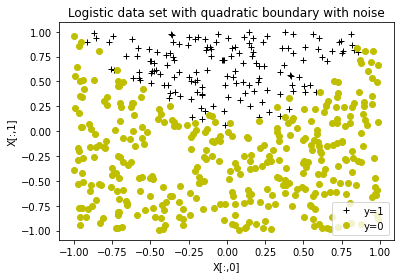

In [9]:
m = 500
n = 2
np.random.seed(1)
X_orig = 2*(np.random.rand(m,n)-[0.5,0.5])
y_train =  X_orig[:,1]  > X_orig[:,0]**2 + 0.2*np.random.rand(m)   #quadratic + random
plot_data(X_orig,y_train)
plt.title("Logistic data set with quadratic boundary with noise")
plt.show()

<a name='FeatureMap'></a>
##  Create Overfitting...Polynomial Feature Mapping
In real data sets, the boundary between "True" and "False" features is rarely a straight line. To create a non-linear decision boundary, our model will need to support non-linear features. Concretely, if we have two features in our feature set $x_1$ and $x_2$ we can build a model of degree 2:
$$f_\mathbf{w} = w_0 + w_1x_1 + w_2x_2 + w_3x_1^2 + w_4x_1x_2 + w_5x_2^2 \tag{1} $$
To do this, we must convert our two feature data set into a 6 feature data set, noting that,as usual, $x_0$ will be set to 1. The routine `map_feature` was provided above to do exactly this.

In [11]:
X_tmp = np.array([[2,0],[0,3],[2,3]] )  # values selected to illustrated equation
print("Shape before feature mapping:", X_tmp.shape)
print(X_tmp, "\n")

mapped_X =  map_feature(X_tmp[:, 0], X_tmp[:, 1],degree = 2)

print("Shape after feature mapping:", mapped_X.shape)
print(mapped_X)

Shape before feature mapping: (3, 2)
[[2 0]
 [0 3]
 [2 3]] 

Shape after feature mapping: (3, 6)
[[1. 2. 0. 4. 0. 0.]
 [1. 0. 3. 0. 0. 9.]
 [1. 2. 3. 4. 6. 9.]]


Compare the results with equation (1) above.

Of course, we don't have to stop at two. The `degree` argument to map_features will determine the degree of the polynomial that is created. The degree will be determined by the complexity of the curve you are trying to follow. Increasing the degree will allow the model to follow more irregular boundaries, but can also allow for overfitting. The number of features/parameters grows exponentially as all of the cross terms are included. Sklearn [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) can also be used to create feature maps.

Lets convert our dataset above to support degree 6.

In [12]:
print("Original shape of data:", X_orig.shape)
degree = 6
mapped_X =  map_feature(X_orig[:, 0], X_orig[:, 1],degree)

print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (500, 2)
Shape after feature mapping: (500, 28)


Note, with a degree 6 polynomial, we now have 28 features!
<a name='FitModel'></a>
## Fit the model

We are going to use the `LogisticRegression` feature of SkLearn that was introduced in a previous lab. One thing to note, this routine has regularization built in. We will enable and disable that capability to highlight aspects of over fitting. To disable it, the command line argument `penalty` is set to `none`. When enabled, the `C` command line argument controls how much regularization is used. 

In [13]:
# create and fit the model using our mapped_X feature set.
lr = LogisticRegression(penalty='none', max_iter=10000)
lr.fit(mapped_X,y_train)

# print an evaluation of the fit, 1 is best.
print(lr.score(mapped_X, y_train))

1.0


Now that we have a trained model, lets map the Original Data (not predicted) along with the decision boundary we derive from the model. Examine `plot_decision_boundary` above to see the details of how this is accomplished.

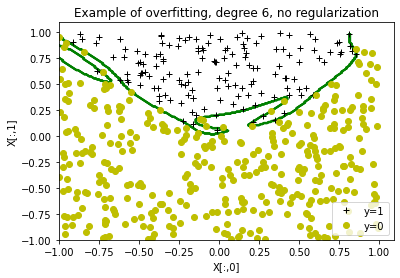

In [14]:
plot_decision_boundary([-1,1],[-1,1], y_train,lr.predict)
plot_data(X_orig,y_train)
plt.title("Example of overfitting, degree 6, no regularization")
plt.show()

Wow, the model has done an amazing job of separating the data! However, that is probably not what is desired. 
We can take two approaches to reducing overfitting:
- regularization 
- reduce the degree of the polynomial.

<a name='ReduceOverfitting'></a>
## Reducing Overfitting using regularization
The next labs will cover regularization in more detail, so we will just explore this briefly.
Lets fit the model again, but this time include regularization. 

In [15]:
# create and fit the model using our mapped_X feature set.
lr = LogisticRegression(max_iter=1000, C=1)
lr.fit(mapped_X,y_train)

# print an evaluation of the fit, 1 is best.
print("fitting score:",lr.score(mapped_X, y_train))

fitting score: 0.966


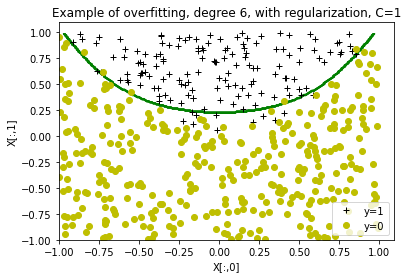

In [16]:
plot_decision_boundary([-1,1],[-1,1], y_train,lr.predict)
plot_data(X_orig,y_train)
plt.title("Example of overfitting, degree 6, with regularization, C=1")
plt.show()

The decision boundary is much more reasonable with some regularizationg.
Change the value of `C` above to try more or less regularization. C must be strictly positive. Values less than 1 maximumize regularization while large values minimize regularization.

## Reduce the degree of the polynomial
A degree 6 polynomial may be more than is required! We can reduce the values to limit the model.
To do this, we will need to regenerate our mapped data and refit the model.

In [17]:
print("Original shape of data:", X_orig.shape)
degree = 2
mapped_X =  map_feature(X_orig[:, 0], X_orig[:, 1],degree)

print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (500, 2)
Shape after feature mapping: (500, 6)


In [18]:
# create and fit the model using our mapped_X feature set.
lr = LogisticRegression(penalty='none', max_iter=1000, C=1)
lr.fit(mapped_X,y_train)

# print an evaluation of the fit, 1 is best.
print("fit score:", lr.score(mapped_X, y_train))

fit score: 0.968


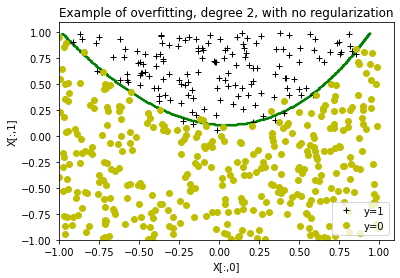

In [20]:
plot_decision_boundary([-1,1],[-1,1], y_train,lr.predict)
plot_data(X_orig,y_train)
plt.title("Example of overfitting, degree 2, with no regularization")
plt.show()

Not bad! Of course, in this case, we knew ahead of time the data was quadratic and that a degree two polynomial would be a good choice. Try varying `degree` above to see the impact of polynomial degree on overfitting.